In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

filepath = '/content/gdrive/My Drive/' + 'Colab Notebooks/'


cmt = pd.read_csv(filepath + '3952개 댓글.csv')
# value = 0:부정 1:긍정 2:관련없음

Mounted at /content/gdrive


In [ ]:
# 데이터 전처리

print('전처리 전 훈련용 샘플의 개수 :',len(cmt))

# comment 열의 중복 제거
cmt.drop_duplicates(subset=['comment'], inplace=True)
# null값이 존재하는 행 제거
cmt = cmt.dropna(how='any')
# 한글과 공백을 제외하고 모두 제거
cmt['comment'] = cmt['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

print('전처리 후 훈련용 샘플의 개수 :',len(cmt))

print(cmt.shape)

전처리 전 훈련용 샘플의 개수 : 3951
전처리 후 훈련용 샘플의 개수 : 3580
(3580, 2)


<ipython-input-7-6a59472e3931>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  cmt['comment'] = cmt['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580 entries, 0 to 3946
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  3580 non-null   object 
 1   value    3580 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.9+ KB


Text(0, 0.5, 'number')

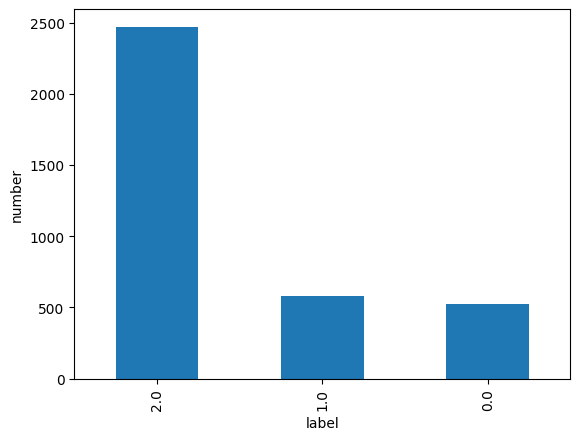

In [ ]:
cmt['value'].value_counts().plot(kind = 'bar')
plt.xlabel("label")
plt.ylabel("number")

In [ ]:
cmt['value'].value_counts(normalize=True)

2.0    0.690223
1.0    0.163128
0.0    0.146648
Name: value, dtype: float64

In [ ]:
x_data = cmt['comment']
y_data = cmt['value']

In [ ]:
ts = 0.2
rs = 42
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size = ts,
                                                    random_state = rs,
                                                    stratify = y_data)

In [ ]:
print(f"훈련 입력 데이터 개수: {len(x_train)}")
print(f"테스트 입력 데이터 개수: {len(x_test)}")

훈련 입력 데이터 개수: 2864
테스트 입력 데이터 개수: 716


In [ ]:
y_train.value_counts(normalize=True)

2.0    0.690293
1.0    0.163059
0.0    0.146648
Name: value, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

2.0    0.689944
1.0    0.163408
0.0    0.146648
Name: value, dtype: float64

In [ ]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [ ]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(x_train, y_train)

# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(x_test, y_test)

2864it [00:01, 1766.78it/s]
716it [00:00, 1784.73it/s]


In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [ ]:
bert_output = bert_outputs[0]

In [ ]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [ ]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [ ]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [ ]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = filepath + 'model/best_model.pb'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

In [ ]:
EPOCHS = 20
BATCH_SZIE = 32

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/20
90/90 [==============================] - ETA: 0s - loss: 1.0999 - accuracy: 0.3331
Epoch 1: val_loss improved from inf to 1.09687, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 148s 1s/step - loss: 1.0999 - accuracy: 0.3331 - val_loss: 1.0969 - val_accuracy: 0.4106
Epoch 2/20
90/90 [==============================] - ETA: 0s - loss: 1.0885 - accuracy: 0.5733
Epoch 2: val_loss improved from 1.09687 to 1.07404, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 107s 1s/step - loss: 1.0885 - accuracy: 0.5733 - val_loss: 1.0740 - val_accuracy: 0.6899
Epoch 3/20
90/90 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.6295
Epoch 3: val_loss improved from 1.07404 to 1.03932, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 109s 1s/step - loss: 1.0568 - accuracy: 0.6295 - val_loss: 1.0393 - val_accuracy: 0.6899
Epoch 4/20
90/90 [==============================] - ETA: 0s - loss: 1.0336 - accuracy: 0.6177
Epoch 4: val_loss improved from 1.03932 to 1.01387, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 115s 1s/step - loss: 1.0336 - accuracy: 0.6177 - val_loss: 1.0139 - val_accuracy: 0.6899
Epoch 5/20
90/90 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.6201
Epoch 5: val_loss improved from 1.01387 to 0.98726, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 110s 1s/step - loss: 1.0090 - accuracy: 0.6201 - val_loss: 0.9873 - val_accuracy: 0.6899
Epoch 6/20
90/90 [==============================] - ETA: 0s - loss: 0.9837 - accuracy: 0.6177
Epoch 6: val_loss improved from 0.98726 to 0.95976, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 109s 1s/step - loss: 0.9837 - accuracy: 0.6177 - val_loss: 0.9598 - val_accuracy: 0.6899
Epoch 7/20
90/90 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.6390
Epoch 7: val_loss improved from 0.95976 to 0.90844, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 109s 1s/step - loss: 0.9467 - accuracy: 0.6390 - val_loss: 0.9084 - val_accuracy: 0.7360
Epoch 8/20
90/90 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.6700
Epoch 8: val_loss improved from 0.90844 to 0.86907, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 112s 1s/step - loss: 0.8902 - accuracy: 0.6700 - val_loss: 0.8691 - val_accuracy: 0.7193
Epoch 9/20
90/90 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.7015
Epoch 9: val_loss improved from 0.86907 to 0.80883, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 110s 1s/step - loss: 0.8269 - accuracy: 0.7015 - val_loss: 0.8088 - val_accuracy: 0.7388
Epoch 10/20
90/90 [==============================] - ETA: 0s - loss: 0.7648 - accuracy: 0.7577
Epoch 10: val_loss improved from 0.80883 to 0.76491, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 108s 1s/step - loss: 0.7648 - accuracy: 0.7577 - val_loss: 0.7649 - val_accuracy: 0.7500
Epoch 11/20
90/90 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7909
Epoch 11: val_loss improved from 0.76491 to 0.72971, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 114s 1s/step - loss: 0.7053 - accuracy: 0.7909 - val_loss: 0.7297 - val_accuracy: 0.7458
Epoch 12/20
90/90 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.8135
Epoch 12: val_loss improved from 0.72971 to 0.72870, saving model to /content/gdrive/My Drive/Colab Notebooks/model/best_model.pb


90/90 [==============================] - 113s 1s/step - loss: 0.6484 - accuracy: 0.8135 - val_loss: 0.7287 - val_accuracy: 0.7360
Epoch 13/20
90/90 [==============================] - ETA: 0s - loss: 0.6160 - accuracy: 0.8076
Epoch 13: val_loss did not improve from 0.72870
90/90 [==============================] - 46s 515ms/step - loss: 0.6160 - accuracy: 0.8076 - val_loss: 0.7415 - val_accuracy: 0.7165
Epoch 14/20
90/90 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.8268
Epoch 14: val_loss did not improve from 0.72870
90/90 [==============================] - 46s 506ms/step - loss: 0.5748 - accuracy: 0.8268 - val_loss: 0.7329 - val_accuracy: 0.7304
Epoch 15/20
90/90 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.8275
Epoch 15: val_loss did not improve from 0.72870
90/90 [==============================] - 46s 511ms/step - loss: 0.5473 - accuracy: 0.8275 - val_loss: 0.7525 - val_accuracy: 0.7332
